In [1]:
# Import OS libraries
import os
import itertools

# Data handling tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report


# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


# Check GPU availability
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

sns.set_style('whitegrid')

2024-10-02 10:21:17.760315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 10:21:17.760438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 10:21:17.910053: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is available


In [2]:
# Specify the path to the dataset
train_brain_tumor_mri_dataset = "/kaggle/input/brain-tumor-mri-dataset/Training"

# Initialize lists to store file paths and labels
data = []


# Loop through each class folder
for tumor_type in os.listdir(train_brain_tumor_mri_dataset):
    tumor_type_path = os.path.join(train_brain_tumor_mri_dataset, tumor_type)
    
    # Loop through each image in the class folder
    for filename in os.listdir(tumor_type_path):
        img_path = os.path.join(tumor_type_path, filename)
        
        # Assign label based on folder name
        label = tumor_type
        
        # Append data tuple (image path, label) to the list
        data.append((img_path, label))

# Create a DataFrame from the list
train = pd.DataFrame(data, columns=['image_path', 'label'])

train.head()

,image_path,label
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary


In [4]:
# Specify the path to the dataset
test_brain_tumor_mri_dataset = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# Initialize lists to store file paths and labels
data = []

# Loop through each class folder
for tumor_type in os.listdir(test_brain_tumor_mri_dataset):
    tumor_type_path = os.path.join(test_brain_tumor_mri_dataset, tumor_type)
    
    # Loop through each image in the class folder
    for filename in os.listdir(tumor_type_path):
        img_path = os.path.join(tumor_type_path, filename)
        
        # Assign label based on folder name
        label = tumor_type
        
        # Append data tuple (image path, label) to the list
        data.append((img_path, label))

# Create a DataFrame from the list
test = pd.DataFrame(data, columns=['image_path', 'label'])

test.head()

,image_path,label
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


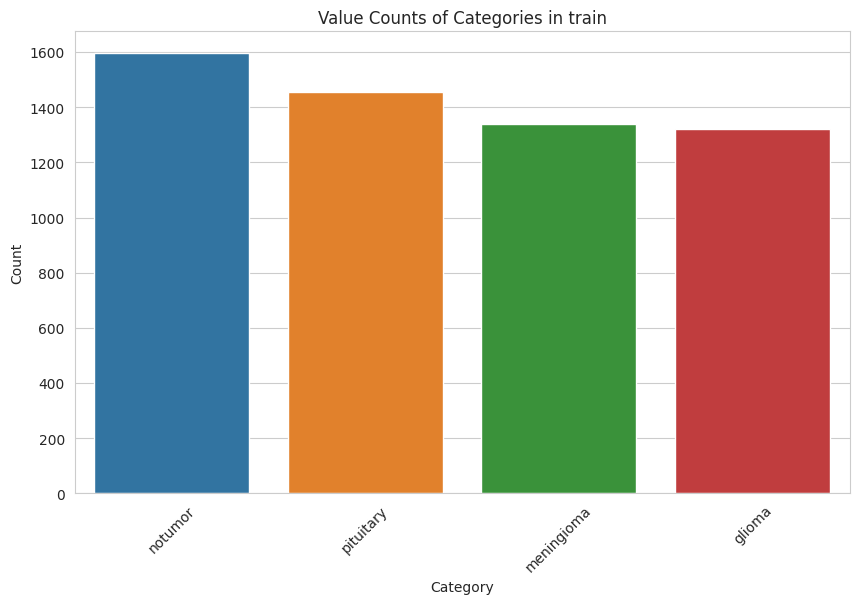

In [5]:
value_counts = train['label'].value_counts()

# Convert the Series to a DataFrame for easier plotting
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['Category', 'Count']

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Count', data=value_counts_df)
plt.xticks(rotation=45)
plt.title('Value Counts of Categories in train')
plt.show()

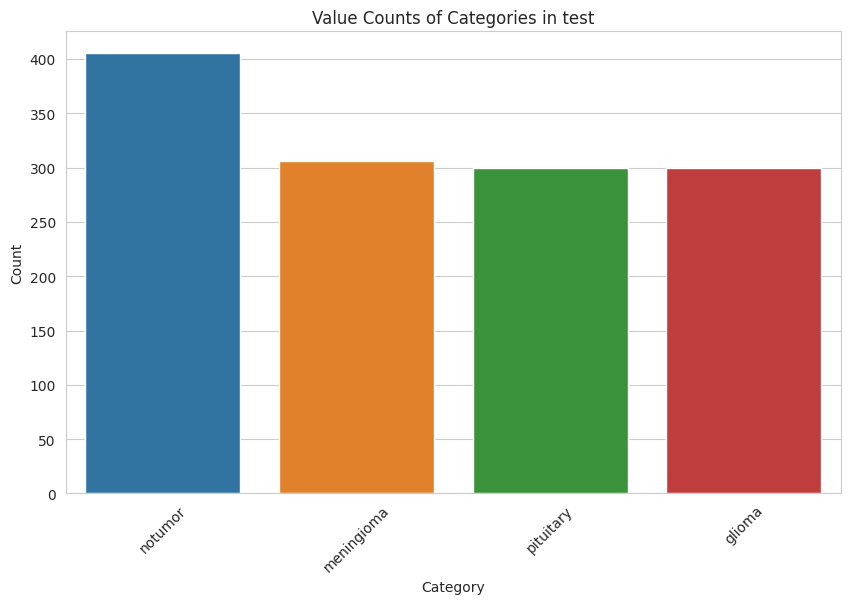

In [6]:
value_counts = test['label'].value_counts()

# Convert the Series to a DataFrame for easier plotting
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['Category', 'Count']

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Count', data=value_counts_df)
plt.xticks(rotation=45)
plt.title('Value Counts of Categories in test')
plt.show()

In [8]:
train_data, valid_data = train_test_split(train, test_size=0.2, random_state=42, shuffle = True , stratify=train['label'])

# Display the shape of the resulting sets
print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {valid_data.shape}")
print(f"Testing set shape: {test.shape}")

Training set shape: (4569, 2)
Validation set shape: (1143, 2)
Testing set shape: (1311, 2)


In [9]:
from imblearn.under_sampling import RandomUnderSampler

X_train = train_data.drop(columns=['label'])
y_train = train_data['label']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

train_data = pd.concat([X_resampled, y_resampled], axis=1)

train_data['label'].value_counts()


label
glioma        1057
meningioma    1057
notumor       1057
pituitary     1057
Name: count, dtype: int64

In [11]:
# Create an ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255 )
valid_test_datagen = ImageDataGenerator(rescale=1./255) 

# Specify the input size expected by the model
input_size = (224, 224)

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='label',
    target_size=input_size,
    shuffle = True, 
    batch_size=16,
    class_mode='categorical',  
    color_mode = 'rgb'
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='image_path',
    y_col='label',
    target_size=input_size,
    shuffle = True, 
    batch_size=16,
    class_mode='categorical',
    color_mode = 'rgb'
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image_path',
    y_col='label',
    target_size=input_size,
    shuffle=False,  
    batch_size=16,
    class_mode='categorical',
    color_mode = 'rgb'
)

Found 4228 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
sample_images, sample_labels = next(train_generator)

# Display the images and labels
plt.figure(figsize=(12, 12))
for i in range(16):
    image = sample_images[i]
    label_index = np.argmax(sample_labels[i]) 
    label = list(train_generator.class_indices.keys())[label_index]  

    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(label, color='k', fontsize=12)
    plt.axis("off")

plt.show()

In [ ]:
input_shape = (224, 224, 3)  

# Create a Sequential model
model = Sequential()

# Convolutional layers
model.add(Conv2D(512, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.35))

model.add(Dense(4, activation='softmax'))  # Output layer with 4 neurons for the 4 classes

# Compile the model
model.compile(Adamax(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('brain_tumors/best_model.keras', save_best_only=True)

In [ ]:
history = model.fit(train_generator, epochs=20, validation_data=valid_generator,
                    validation_steps = None , shuffle = False,
                    callbacks=[early_stopping, model_checkpoint])

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [ ]:
# Evaluate the model on the training set
train_score = model.evaluate(train_generator)
print(f"Training Loss: {train_score[0]}, Training Accuracy: {train_score[1]}")

# Evaluate the model on the validation set
valid_score = model.evaluate(valid_generator)
print(f"Validation Loss: {valid_score[0]}, Validation Accuracy: {valid_score[1]}")

# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print(f"Test Loss: {test_score[0]}, Test Accuracy: {test_score[1]}")

In [ ]:
preds = model.predict(test_generator)

y_pred = np.argmax(preds, axis=1)

In [ ]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

print(cm)

plt.figure(figsize= (12, 8))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()

plt.show()

In [ ]:
print(classification_report(test_generator.classes, y_pred , target_names= classes ))